# Session 8
## Scraping 2 - Parsing
*Snorre Ralund *

Yesterday I gave you some powerful tricks. Tricks that will work when the data is already shipped in a neat format. However this is not the rule. Today we shall learn the art of parsing unstructured text and a more principled and advanced method of parsing HTML.

This will help you build ***custom datasets*** within just a few hours or days work, that would have taken ***months*** to curate and clean manually.

## Agenda
**Parsing and cleaning raw data** 

HTML
* Understanding the basics of HTML syntax.
* Traversing and Navigating HTML trees using BeautifulSoup. Examples include: 
    * Extracting Text from HTML, 
    * Extracting Tables, 
    * Parsing of "unknown" structures.
_________________________
Raw Text
* Learning the of Regular Expressions for extracting patterns in strings. 
    * Very valuable when cleaning and validating data, and for information extraction from raw text.

_________________________


# Sidestep: Interactions and Automated Browsing
Sometimes scraping tasks demand interactions (e.g. login, scrolling, clicking), and a no XHR data can be found easily, so you need the browser to execute the scripts before you can get the data.

Here we use the `Selenium` package in combination with the `geckodriver` - download the latest release [here](download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases). It allows you to animate a browser. I won't go into detail here, but just wanted to mention it. 

Installation (and maintainance of compatability) can be a little tough, but instead of trawling through crazy stackoverflow threads about your Issue, my experience tells me that downloaded the latest release, and installing the latest selenium version is always the cure.

In [ ]:

from selenium import webdriver
## download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases
path2gecko = 'C:/Users/jbv933/Downloads/geckodriver-v0.21.0-win64/geckodriver.exe' # define path to your geckodriver
browser = webdriver.Firefox(executable_path=path2gecko) # start the browser with a path to the geckodriver.
browser.get('https://www.google.com') # opens a webpage using the browser objects get method.

## The HTML Tree
HTML has a Tree structure. 

Each node in the tree has:
        - Children, siblings, parents - descendants. 
        - Ids and attributes

<img src="http://www.openbookproject.net/tutorials/getdown/css/images/lesson4/HTMLDOMTree.png"/>


## Important syntax and patterns
_______________
```html 
<p>The p tag indicates a paragraph <p/>
```
_______________
```html 
<b>The b tag makes the text bold, giving us a clue to its importance <b/>
```
output: <b>The b tag makes the text bold, giving us a clue to its importance <b/>
___________
```html 
<h1>h1</h1><h2>h2</h2><h2>h3</h3><b>Headers give similar clues</b>
```
output:
<h1>h1</h1><h2>h2</h2><h3>h3</h3><b>Headers give similar clues</b>
_________________
```html 
<a href="www.google.com">The a tag creates a hyperlink <a/>
```
output: <a href="www.google.com">The a tag creates a hyperlink <a/>
_____________
Finally you have the terrible and confusing iframe: 
```html
 <iframe src="https://www.google.com"></iframe>
```
_________________

## How do we find our way around this tree?
* extracting string patterns using .split and regular expresssions as we did yesterday.
* Specifying paths using css-selectors,xpath syntax. 
* A more powerful and principled (+readable) way is to use the ```python``` module ```BeautifulSoup``` to parse and traverse the tree.

### Selectors 
Define a unique path to an element in the HTML tree.
- quick but has to be hardcoded and also more likely to break.


In [4]:
# selenium example
browser.get('https://www.facebook.com')
# find login button.

# define username

# define password

# click on the submit button

## Parsing HTML with BeautifulSoup
BeautifulSoup makes the html tree navigable. 
It allows you to:
    * Search for elements by tag name and/or by attribute.
    * Iterate through them, go up, sideways or down the tree.
    * Furthermore it helps you with standard tasks such as extracting raw text from html,
    which would be a very tedious task if you had to hardcode it using `.split` commands and using your own regular expressions will be unstable.

In [281]:
# scraping newspaper articles example.
url = 'https://www.theguardian.com/us-news/2018/aug/10/omarosa-trump-book-the-apprentice-memoir'
response = requests.get(url)
html = response.text

In [304]:
soup = BeautifulSoup(html,'lxml') # parse the raw html using BeautifoulSoup

In [307]:
# extract hyperlinks
links = soup.find_all('a') # find all a tags -connoting a hyperlink.
[link['href'] for link in links if link.has_attr('href')][0:5] # unpack the hyperlink from the a nodes.

['#maincontent',
 'https://www.theguardian.com/preference/edition/int',
 'https://www.theguardian.com/preference/edition/uk',
 'https://www.theguardian.com/preference/edition/us',
 'https://www.theguardian.com/preference/edition/au']

In [308]:
headline = soup.find('h1') # search for the first headline: h1 tag. 
name = headline['class'][0].strip() # use the class attribute name as column name.
value = headline.text.strip() # extract text using build in method.
print(name,':',value)

content__headline : Omarosa says Trump is a racist who uses N-word – and claims there's tape to prove it


In [309]:
article_text = soup.find('div',{'class':'content__article-body from-content-api js-article__body'}).text # find the content.

Say we are interested in how articles cite sources to back up their story i.e. their hyperlink behaviour within the article, and we want to see if the media has changed their behaviour.

We know how to search for links. But the cool part is that we can search from anywhere in the HTML tree. This means that once we have located the article content node - as above - we can search from there. This results in hyperlinks used within the article text.


In [321]:
# find the article_content node
article_content = soup.find('div',{'class':'content__article-body from-content-api js-article__body'})
# find citations within the article content.
citations = article_content.find_all('a')

In [325]:
citation_links = [] # define container to the hyperlinks
for citation in citations: # iterate through each citation node
    if citation.has_attr('data-link-name'): # check if it has the right attribute
        if citation['data-link-name'] =='in body link': # and if the value of that attribute is correct
            #print(citation['href'])
            citation_links.append(citation['href']) #  add link to the container

## Scraping without hardcoding every element to collect.  
### Hands-on example: Continuing the Cryptomarket scrape. 
When scraping a large and diverse website or even crawling many different, it can be useful to design more generic parsing schemes, were you haven't seen all elements you want to keep before hand. In the following example I demonstrate a simple example of this.

Imagine we wanted data on the Cryptomarkets:
* Go to the front page of a [Cryptomarket page](https://coinmarketcap.com). Looking in the **>Network Monitor<** we find a XHR file (helping their search function) containing links to Cryptocoin. Now we have the link to each page we want to visit. 

Visit this example: http://coinmarketcap.com/currencies/ethereum/

Yesterday we saw how to find the XHR file with the underlying data behind the Chart. Now we want all the metadata displayed. 

Using the inspector we find that the information we want is located by a node tagged with `ul` - *"unordered list"* tag - with the defining class attribute *'list-unstyled details-panel-item--links'*. And the information is located in the `li` tag *"list item"*.

First we locate this node using the `find` method. 


In [216]:
url = 'https://coinmarketcap.com/currencies/ethereum/' # define the example url
response = requests.get(url) # 
soup = BeautifulSoup(response.text,'lxml') # parse the HTML

In [221]:
list_node = soup.find('ul',{'class':'list-unstyled details-panel-item--links'}) # search for the ul node

Now starting from this list_node, we can search for each list item - li node, using the find_all method.

In [326]:
list_items = list_node.find_all('li') # search for all list elements children of the list_node 

From this we extract the information. Without having to hardcode all extractions we exploit that each html node has a attribute ('title'). We can therefore just loop through each node, extracting the title attribute and the text. ***-- This furthermore allows us to scrape content we did not know was there.***

We use the title as the key in the dictionary. The value we are interested in two things, either the *hyperlink*, or the the *text* on display.

In [249]:
d = {} # defining our container
for list_item in list_items:
    key = list_item.span['title'] # attributes of a node can be fetched with dictionary-like syntax.
    if list_item.a!=None: # check if the node has a hyperlink.
        value = list_item.a['href'] # list_item.a ==list_item.find('a') returns the first node found.
    else:
        value = list_item.text.strip()
    d[key] = value
d

{'Announcement': 'https://bitcointalk.org/index.php?topic=428589.0',
 'Chat': 'https://gitter.im/orgs/ethereum/rooms',
 'Explorer': 'https://etherchain.org/',
 'Message Board': 'https://forum.ethereum.org/',
 'Rank': 'Rank 2',
 'Source Code': 'https://github.com/ethereum',
 'Tags': 'Coin\nMineable',
 'Website': 'https://www.ethereum.org/'}

In [280]:


d['Source Code'],d['Source Code'].split('/')[-1]


'ethereum'

# ERC example
Imagine we wanted to analyze whether the European funding behaviour was biased towards certain countries and gender. We might decide to scrape who has received funding from the ERC. 

* First we figure find navigate the grant listings.
* Next we figure out how to page these results. 
* And finally we want to grab the information.


In [2]:
import requests
url = 'https://erc.europa.eu/projects-figures/erc-funded-projects/results?items_per_page=100&f[0]=funding_scheme%3AConsolidator%20Grant%20(CoG)'
response = requests.get(url)

In [166]:
from bs4 import BeautifulSoup
import bs4
soup = BeautifulSoup(response.text,'lxml')

You can search for nodes through their Tag, attribute, or 

In [22]:
result_list = soup.find('div',{'class':'view-content'}) # find elements using tag name and class attribute

In [28]:
for child in result_list.children:
    if type(child)==bs4.NavigableString:
        
        continue
    break

In [206]:

datapoint = {}
for child2 in child.children:
    if type(child2)==bs4.NavigableString:
        continue
    spans = child2.findAll('span')
    
    if len(spans)==2:
        key,value = spans
    else:
        key,value = [i for i in list(child2.find('span').children) if not type(i)==bs4.NavigableString]
    datapoint[key.text] = value.text
    # Finding unknown titles using the strong tag as a clue.
    strong = child2.findAll('strong')
    if len(strong)>0:
        for node in strong:
            key = node.text
            value = str(node.next.next)
            print(key,node.next,value)
    #break
    
    

Max ERC Funding Max ERC Funding 
1 999 172 €

Duration Duration 
Start date: 2014-04-01, End date: 2019-03-31



# Extracting patterns from Raw Text

of course you already now your basic string operations:

`string.split
string.strip
string.replace`

And sometimes this will be enough, but sometimes it is not.

# Regular Expressions
![](https://cdn-images-1.medium.com/max/800/0*j1f-EFL7TDtf6K0o.jpg)

Regex can be a little terrifying:

`pattern = '(?:(?:\r\n)?[ \t])*(?:(?:(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*))*@(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*|(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*)*\<(?:(?:\r\n)?[ \t])*(?:@(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*(?:,@(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*)*:(?:(?:\r\n)?[ \t])*)?(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*))*@(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*\>(?:(?:\r\n)?[ \t])*)|(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*)*:(?:(?:\r\n)?[ \t])*(?:(?:(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*))*@(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*|(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*)*\<(?:(?:\r\n)?[ \t])*(?:@(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*(?:,@(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*)*:(?:(?:\r\n)?[ \t])*)?(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*))*@(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*\>(?:(?:\r\n)?[ \t])*)(?:,\s*(?:(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*))*@(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*|(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*)*\<(?:(?:\r\n)?[ \t])*(?:@(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*(?:,@(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*)*:(?:(?:\r\n)?[ \t])*)?(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*))*@(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*\>(?:(?:\r\n)?[ \t])*))*)?;\s*)'`


However creating regular expressions is also fun, fun as in Suduko, and it is extremely valuable when working with any kind of text: e.g. Automating otherwise tedious manual tasks when cleaning a data set, searching, extracting and substituting specific patterns.

Examples could be: 
- Extract currency and amount from raw text: $ 20, 10.000 dollars 10,000 £
- email addresses: here you want to design a pattern (as above), that captures only the uses of @ within an email.
- urls. Here you are trying to define all the different ways of writing urls (https, http, no http). 
- Dates. Again many variations: 17th of June 2017, 06/17/17 or 17. June 17
- addresses, 
- phone numbers: 8888888 or 88 88 88 88 or +45 88 88 88 88,
- emojiies in text. Capturing all the different ways of expressing smiley faces with one regular expression. 




** Regular Expression syntax **

Ressources:
Best way to learn is to practice, and with interactive examples. Two good ressources are here:
* Community and interactive playground [here](http://regexr.com/)
* Interactive tutorial [here](https://regexone.com/)
* or you can use your notebook.

Lookup all special characters [here](https://www.regular-expressions.info/refquick.html)

* \+ = 1 or more times  -- e.g. "a+" will match: "a", and "aaa"
* \* = 0 or more times  -- e.g. "ba*" will match: "b", and "ba", and "baaa"
* {3} = exactly three times --- e.g. "ba{3}" will match "baaa", but not "baa"
* ? = once or none
* \\ = escape character, used to find characters that has special meaning with regex: e.g. \+ \*
* [] = allows you to define a set of characters
* ^ = applied within a set, it becomes the inverse of the set defined. Applied outside a set it entails the beginning of a string. $ entails the end of a string.
* . = any characters except line break
* | = or statement. -- e.g. a|b means find characters a or b.
* \d = digits
* \D = any-non-digits.
* \s = whitespace-separator

Sequences
* (?:) = Defines a Non-capturing group. -- e.g. "(?:abc)+", will match "abc" and "abcabcabc", but not "aabbcc"
* (?=)	= Positive lookahead - only match a certain pattern if a certain pattern comes after it.
* (?!)	= Negative lookahead - only match a certain pattern if **not** a certain pattern comes after it.
* (?<=)	= Positive lookbehind - only match a certain pattern if a certain pattern precedes it.
* (?<!) = Negative lookbehind - only match a certain pattern if **not** a certain pattern precedes it.

## Regular expressions (2): define - inspect - refine
You are trying to balance getting (and learning/exploring) all the different variations of e.g. an emojii. while also making sure not to include ordinary use of :. 

This means iterating through many steps, some expressions being too broad others being to narrow, and others not matching all that you need.

I developed a small module for this that you can use. Just run the following piece of code to download, save and import the module.

```python 
# download module
url = 'https://raw.githubusercontent.com/snorreralund/explore_regex/master/explore_regex.py'
response = requests.get(url)
# write script to your folder to create a locate module
with open('explore_regex.py','w') as f:
    f.write(response.text)
# import local module
import explore_regex as e_re
```

## Lets do an example
first we get a dataset to play with. 
We download the following link using pandas and dump it to your local machine using the `pd.to_csv()` method.

In [1]:
import pandas as pd
import re
path2data = 'https://raw.githubusercontent.com/snorreralund/scraping_seminar/master/danish_review_sample.csv'
df = pd.read_csv(path2data)
df.to_csv('danish_review_sample.csv',index=False)

digit_re = re.compile('[0-9]+') # compiled regular expression for matching digits
df['hasNumber'] = df.reviewBody.apply(lambda x: len(digit_re.findall(x))>0) # check if it has a number


In [2]:
sample_string = '\n'.join(df[df.hasNumber].sample(2000).reviewBody)

In [3]:
import explore_regex as e_re
%matplotlib inline

In [4]:
# money example
#explore_money = ExploreRegex(sample_string)
explore_money = e_re.ExploreRegex(sample_string)
first = 'kr'
second = '[0-9]+kr'
third = '[0-9]+(?:[,.][0-9]+)?kr'
fourth = '[0-9]+(?:[,.][0-9]+)?\s{0,2}kr'
final = '[0-9]+(?:[,.][0-9]+)?\s{0,5}kr(?:oner)?'
patterns = [first,second,third,fourth,final]
for pattern in patterns:
    explore_money.explore_difference(pattern,patterns[0])
explore_money.explore_pattern(second)

------ Pattern: kr	 Matched 1071 patterns -----
Found 0 overlaps between the expressions:
        pattern1: kr 	 and
        pattern2: kr
        1071 included in pattern1 and not in the pattern2
        1071 was included in pattern2 and not in pattern1
------ Pattern: [0-9]+kr	 Matched 83 patterns -----
Found 166 overlaps between the expressions:
        pattern1: [0-9]+kr 	 and
        pattern2: kr
        0 included in pattern1 and not in the pattern2
        988 was included in pattern2 and not in pattern1
------ Pattern: [0-9]+(?:[,.][0-9]+)?kr	 Matched 83 patterns -----
Found 166 overlaps between the expressions:
        pattern1: [0-9]+(?:[,.][0-9]+)?kr 	 and
        pattern2: kr
        0 included in pattern1 and not in the pattern2
        988 was included in pattern2 and not in pattern1
------ Pattern: [0-9]+(?:[,.][0-9]+)?\s{0,2}kr	 Matched 343 patterns -----
Found 686 overlaps between the expressions:
        pattern1: [0-9]+(?:[,.][0-9]+)?\s{0,2}kr 	 and
        pattern2: 

------ Pattern: kr	 Matched 1071 patterns -----
------ Pattern: [0-9]+kr	 Matched 83 patterns -----
------ Pattern: [0-9]+(?:[,.][0-9]+)?kr	 Matched 83 patterns -----
------ Pattern: [0-9]+(?:[,.][0-9]+)?\s{0,2}kr	 Matched 343 patterns -----
------ Pattern: [0-9]+(?:[,.][0-9]+)?\s{0,5}kr(?:oner)?	 Matched 343 patterns -----


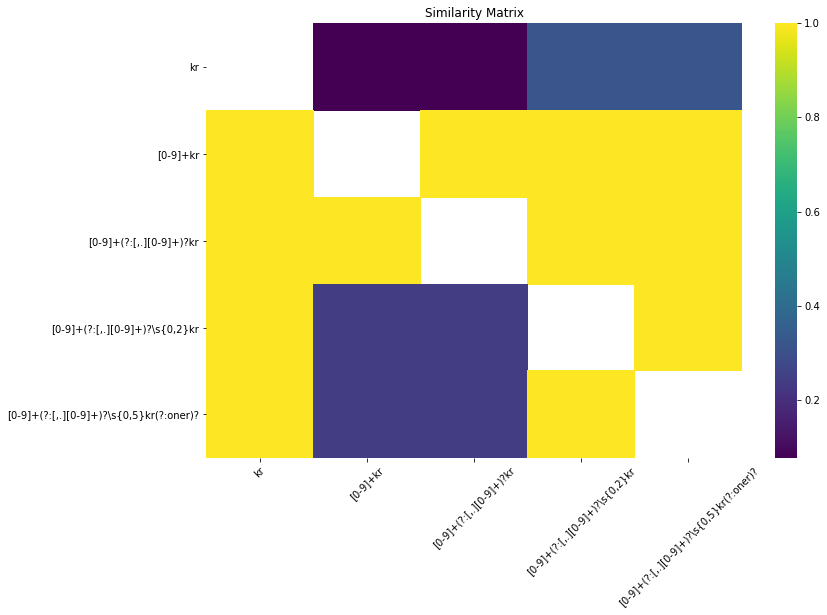

In [5]:
explore_money.report('soft')

------ Pattern: kr	 Matched 1071 patterns -----
------ Pattern: [0-9]+kr	 Matched 83 patterns -----
------ Pattern: [0-9]+(?:[,.][0-9]+)?kr	 Matched 83 patterns -----
------ Pattern: [0-9]+(?:[,.][0-9]+)?\s{0,2}kr	 Matched 343 patterns -----
------ Pattern: [0-9]+(?:[,.][0-9]+)?\s{0,5}kr(?:oner)?	 Matched 343 patterns -----


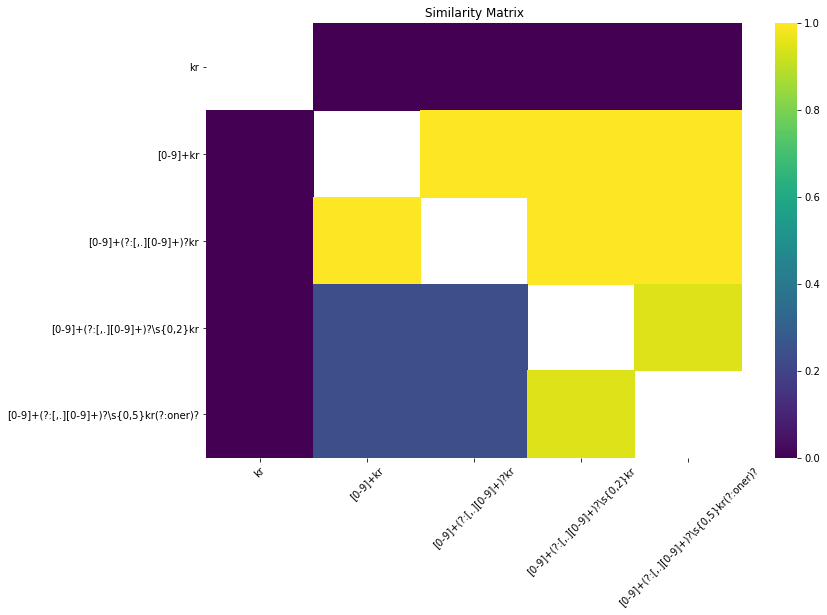

In [6]:
explore_money.report('hard')

In [7]:
print(explore_money.patterns[3],explore_money.patterns[4])
explore_money.explore_difference(explore_money.patterns[3],explore_money.patterns[4])

[0-9]+(?:[,.][0-9]+)?\s{0,2}kr [0-9]+(?:[,.][0-9]+)?\s{0,5}kr(?:oner)?
Found 686 overlaps between the expressions:
        pattern1: [0-9]+(?:[,.][0-9]+)?\s{0,2}kr 	 and
        pattern2: [0-9]+(?:[,.][0-9]+)?\s{0,5}kr(?:oner)?
        0 included in pattern1 and not in the pattern2
        0 was included in pattern2 and not in pattern1


([], [])